In [1]:
import numpy as np
from numpy import random
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import rel_entr
#import pickle

import genexpr
from genexpr.twostagemodel import TwoStageModel

In [2]:
def KL_div(P, Q):
    """
    Kullback-Leibler divergence D_KL(P || Q) between discrete distributions P and Q. The lengths of P and Q must match.

    Inputs:
        - P [ndarray, shape=(N,)]: array containing p.m.f of P
        - Q [ndarray, shape=(N,)]: array containing p.m.f of Q
            
    Outputs: 
        - D_KL [float]: Kullback-Leibler divergence D_KL(P || Q)
    """

    if len(P) != len(Q):
        return np.inf
    if not(isinstance(P, np.ndarray) and isinstance(Q, np.ndarray)):
        P, Q = np.asarray(P), np.asarray(Q)

    return np.sum(rel_entr(P,Q))


# Part 1: Simulation of paper results
## Two-stage model

- $a = \nu_0 / d_1$
- $b = \nu_1 / d_0$
- $\gamma = d_0 / d_1$
- $\tau = d_1 t$

In [3]:
twostage = TwoStageModel()

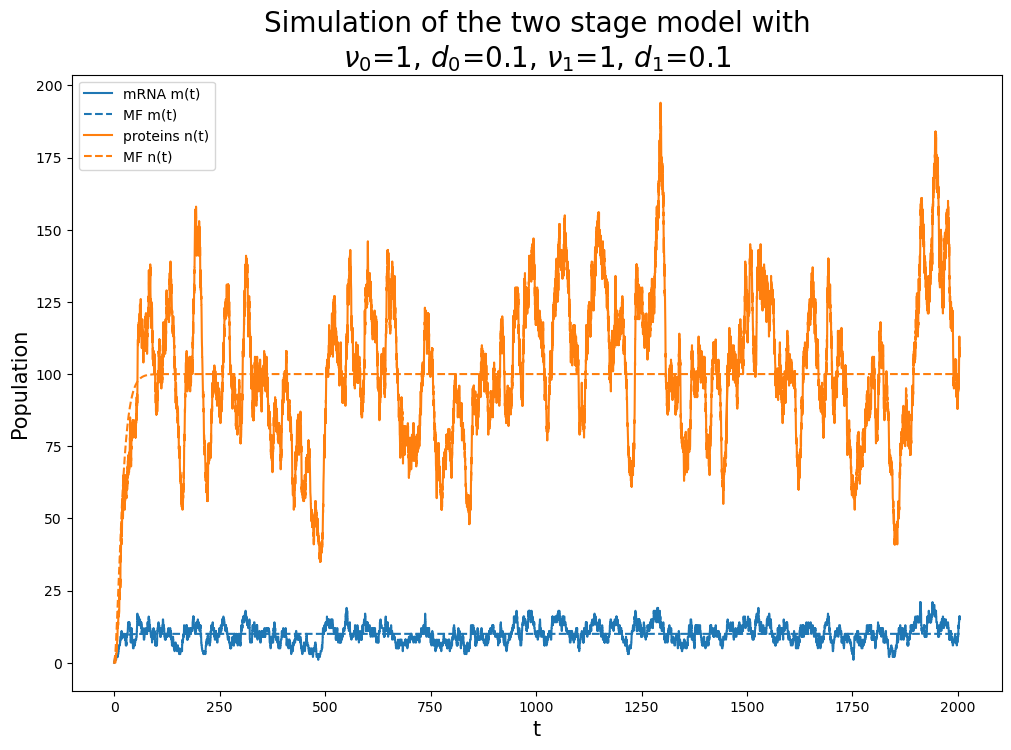

In [4]:
# initializations
t = 0.0
x = np.array([0,0])

nu0, d0, nu1, d1 = 1, 0.1, 1, 0.1
args = [nu0, d0, nu1, d1]


# Gillespie iterations
tstat=2.0e3
(m_t, n_t), t_t = twostage.Gillespie_simulation(x, t, tstat, 100, args, keep_transient=True)


# Mean field solution
m_MF_t, n_MF_t = twostage.mean_field_prediction(np.array([0,0]), t_t, args)


# plots
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.plot(t_t, m_t, label="mRNA m(t)")
ax.plot(t_t, m_MF_t, "--", color="C0", label="MF m(t)")
ax.plot(t_t, n_t, label="proteins n(t)")
ax.plot(t_t, n_MF_t, "--", color="C1", label="MF n(t)")

ax.set_title("Simulation of the two stage model with\n" + fr"$\nu_0$={nu0}, $d_0$={d0}, $\nu_1$={nu1}, $d_1$={d1}", fontsize=20)
ax.set_xlabel("t", fontsize=15)
ax.set_ylabel("Population", fontsize=15)
ax.legend()

### Figure 1B


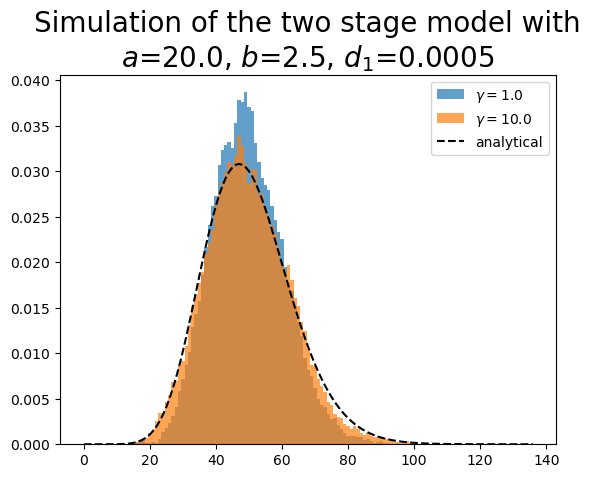

In [5]:
# gamma = 1.0
gamma, a, b, d1 = 1.0, 20.0, 2.5, 5e-4
args = (a*d1, gamma*d1, b*gamma*d1, d1)
tstat = 10.0/d1
(_, n_hist), _ = twostage.Gillespie_simulation(np.array([0,0]), 0, tstat, Nsim=100000, args=args, dt=0.01/d1, keep_transient=False)
h_, n_, _ = plt.hist(n_hist, bins=np.arange(start=-0.5, stop=max(n_hist)+0.5, step=1), density=True, label=rf"$\gamma = ${gamma}", alpha=0.7)
max_n = max(n_hist)

# gamma = 10.0
gamma, a, b, d1 = 10.0, 20.0, 2.5, 5e-4
args = (a*d1, gamma*d1, b*gamma*d1, d1)
tstat = 10.0/d1
(_, n_hist), _ = twostage.Gillespie_simulation(np.array([0,0]), 0, tstat, Nsim=100000, args=args, dt=0.01/d1, keep_transient=False)
h_, n_, _ = plt.hist(n_hist, bins=np.arange(start=-0.5, stop=max(n_hist)+0.5, step=1), density=True, label=rf"$\gamma = ${gamma}", alpha=0.7)
max_n = max(max_n, max(n_hist))


# analytical plot
n0 = np.arange(max_n+30)
fn_analytical = twostage.analytical_stationary(n0, args, normalize=True)
plt.plot(n0, fn_analytical, "--", c="black", label="analytical")
plt.title("Simulation of the two stage model with\n" + fr"$a$={a}, $b$={b}, $d_1$={d1}", fontsize=20)
plt.legend()

### Figure 1C


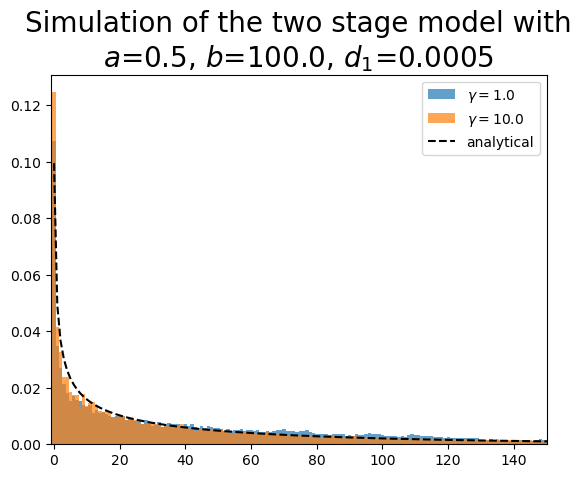

In [6]:
# gamma = 1.0
gamma, a, b, d1 = 1.0, 0.5, 100.0, 5e-4
args = (a*d1, gamma*d1, b*gamma*d1, d1)
tstat = 10.0/d1
(_, n_hist), _ = twostage.Gillespie_simulation(np.array([0,0]), 0, tstat, Nsim=100000, args=args, dt=0.01/d1, keep_transient=False)
h_, n_, _ = plt.hist(n_hist, bins=np.arange(start=-0.5, stop=max(n_hist)+0.5, step=1), density=True, label=rf"$\gamma = ${gamma}", alpha=0.7)
max_n = max(n_hist)

# gamma = 10.0
gamma, a, b, d1 = 10.0, 0.5, 100.0, 5e-4
args = (a*d1, gamma*d1, b*gamma*d1, d1)
tstat = 10.0/d1
(_, n_hist), _ = twostage.Gillespie_simulation(np.array([0,0]), 0, tstat, Nsim=100000, args=args, dt=0.01/d1, keep_transient=False)
h_, n_, _ = plt.hist(n_hist, bins=np.arange(start=-0.5, stop=max(n_hist)+0.5, step=1), density=True, label=rf"$\gamma = ${gamma}", alpha=0.7)
max_n = max(max_n, max(n_hist))


# analytical plot
n0 = np.arange(max_n+30)
fn_analytical = twostage.analytical_stationary(n0, args, normalize=True)
plt.plot(n0, fn_analytical, "--", c="black", label="analytical")
plt.xlim(-1,150)
plt.title("Simulation of the two stage model with\n" + fr"$a$={a}, $b$={b}, $d_1$={d1}", fontsize=20)
plt.legend()

### Figure 1D

In [7]:
gammas = np.logspace(-2, 2, num=15, base=10)
args_ = [(20.0, 2.5, 5e-4), (0.5, 100.0, 5e-4)]
res = {}

for arg_ in args_:
    res[f"{arg_[0]}_{arg_[1]}"] = {"D_KL":[], "gamma":[]}

    for gamma_ in gammas:
        a_, b_, d1_ = arg_
        args = (a_*d1_, gamma_*d1_, b_*gamma_*d1_, d1_)
        tstat_ = 10.0/d1_

        (_, n_hist), _ = twostage.Gillespie_simulation(np.array([0,0]), 0, tstat, Nsim=100000, args=args, dt=0.01/d1, keep_transient=False)
        h_, n_, _ = plt.hist(n_hist, bins=np.arange(start=-0.5, stop=max(n_hist)+0.5, step=1), density=True)
        n0 = np.arange(len(h_)+30)
        fn_analytical = twostage.analytical_stationary(n0, args, normalize=True)
        plt.clf()

        res[f"{arg_[0]}_{arg_[1]}"]["D_KL"].append(KL_div(h_, fn_analytical[:len(h_)]))
        res[f"{arg_[0]}_{arg_[1]}"]["gamma"].append(gamma_)

<Figure size 640x480 with 0 Axes>

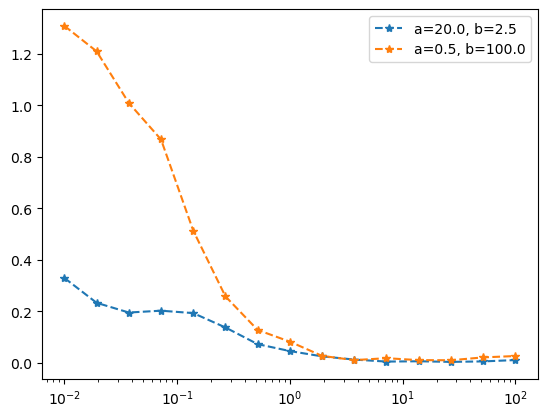

In [8]:
for (a_,b_,_) in args_:
    data = res[f"{a_}_{b_}"]
    plt.plot(data["gamma"], data["D_KL"], "*--", label=f"a={a_}, b={b_}")
plt.xscale("log")
plt.legend()

### Figure 2A

In [9]:
gamma, a, b, d1 = 10.0, 20.0, 2.5, 5e-4
args = (a*d1, gamma*d1, b*gamma*d1, d1)
tslice = np.array([0.01, 0.2, 0.8, 2, 10]) / d1

(_, n_hist) = twostage.Gillespie_simulation_transient(np.array([0,0]), 0, tslice, Nsim=1000, args=args)

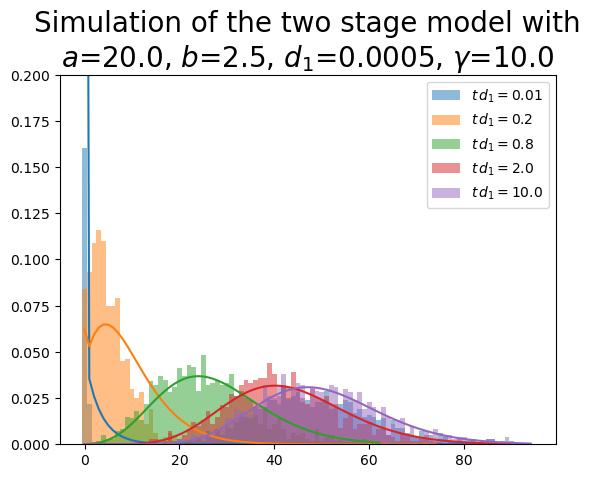

In [10]:
for t_, n_t in enumerate(n_hist):
    plt.hist(n_t, bins=np.arange(start=-0.5, stop=max(n_t)+0.5, step=1), density=True, alpha=0.5, label=f"$t\, d_1 = ${np.round(tslice[t_]*d1, 2)}")

    n0 = np.arange(max(n_t))
    plt.plot(n0, twostage.analytical_transient(n0, tslice[t_], 0, args=args, normalize=True), ls="-", c="C"+str(t_))

plt.title("Simulation of the two stage model with\n" + fr"$a$={a}, $b$={b}, $d_1$={d1}, $\gamma$={gamma}", fontsize=20)
plt.ylim(0,0.2)
plt.legend()

### Figure 2B

In [11]:
gamma, a, b, d1 = 10.0, 0.5, 100.0, 5e-4
args = (a*d1, gamma*d1, b*gamma*d1, d1)
tslice = np.array([0.01, 0.2, 0.8, 2, 10]) / d1

(_, n_hist) = twostage.Gillespie_simulation_transient(np.array([0,50]), 0, tslice, Nsim=1000, args=args)

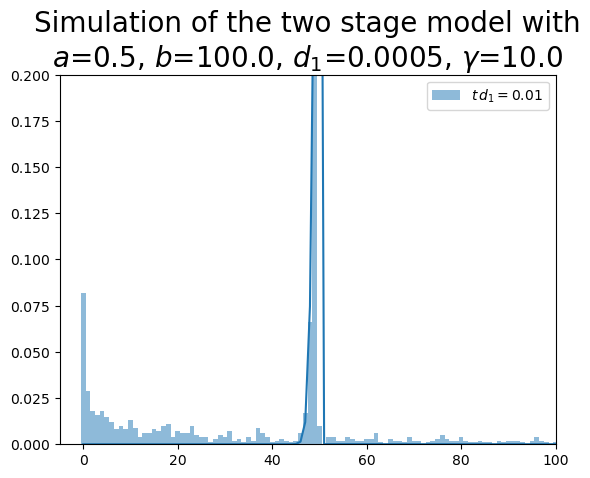

In [16]:
for t_, n_t in enumerate(n_hist):
    plt.hist(n_t, bins=np.arange(start=-0.5, stop=max(n_t)+0.5, step=1), density=True, alpha=0.5, label=f"$t\, d_1 = ${np.round(tslice[t_]*d1, 2)}")

    n0 = np.arange(max(n_t))
    plt.plot(n0, twostage.analytical_transient(n0, tslice[t_], 50, args=args, normalize=True), c="C"+str(t_), ls="-")

plt.title("Simulation of the two stage model with\n" + fr"$a$={a}, $b$={b}, $d_1$={d1}, $\gamma$={gamma}", fontsize=20)
plt.xlim(-5, 100)
plt.ylim(0, 0.2)
plt.legend()

### Figure 2C

In [39]:
taus = np.logspace(-2, 1, num=15, base=10)
args_ = [(10.0, 20.0, 2.5, 5e-4), (10.0, 0.5, 100.0, 5e-4)]
x0s = [np.array([0,0]), np.array([0,50])]
res = {}

for x0_, arg_ in zip(x0s, args_):
    res[f"{arg_[1]}_{arg_[2]}"] = {"D_KL":[], "tau":[]}

    for tau_ in taus:
        gamma_, a_, b_, d1_ = arg_
        args = (a_*d1_, gamma_*d1_, b_*gamma_*d1_, d1_)
        
        n_hist = twostage.Gillespie_simulation_transient(x0_, 0, np.array([tau_/d1_]), Nsim=1000, args=args)[1,0,:]
        h_, n_, _ = plt.hist(n_hist, bins=np.arange(start=-0.5, stop=max(n_hist)+0.5, step=1), density=True)
        n0 = np.arange(len(h_)+30)
        fn_analytical = twostage.analytical_transient(n0, tau_/d1_, int(x0_[1]), args, normalize=True)
        plt.clf()

        res[f"{arg_[1]}_{arg_[2]}"]["D_KL"].append(KL_div(h_, fn_analytical[:len(h_)]))
        res[f"{arg_[1]}_{arg_[2]}"]["tau"].append(tau_)

<Figure size 640x480 with 0 Axes>

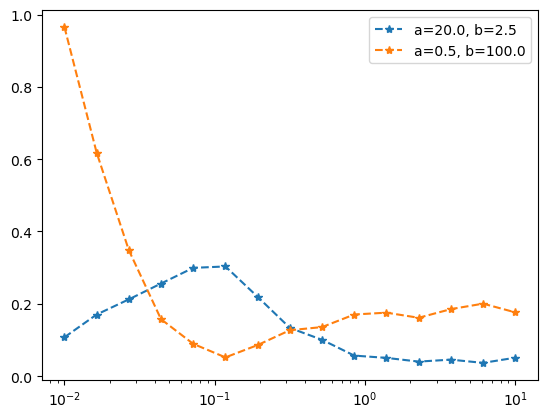

In [40]:
for (_,a_,b_,_) in args_:
    data = res[f"{a_}_{b_}"]
    plt.plot(data["tau"], data["D_KL"], "*--", label=f"a={a_}, b={b_}")
plt.xscale("log")
plt.legend()

### Figure 2D

In [ ]:
## implementa simulazione con propagatore :_(

## Three-stage model

# Part 2: simulation with real data

In [ ]:
data = pd.read_csv("data/data_LN_PST_MB.csv")
data

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,9537,9538,9539,9540,9541,9542,9543,9544,9545,9546
0,Klf4,1.237182,1.233101,1.243267,1.243267,1.258404,1.267722,1.283406,1.280832,1.280832,...,0.219237,0.219237,0.219237,0.219237,0.219237,0.219237,0.219237,0.219237,0.228717,0.228717
1,Klf2,1.143295,1.152089,1.142363,1.142363,1.148623,1.156669,1.146918,1.144345,1.160804,...,0.603555,0.594118,0.579160,0.579160,0.567149,0.567149,0.561093,0.561093,0.547104,0.538954
2,Esrrb,0.279826,0.288620,0.294988,0.287320,0.273908,0.284033,0.296715,0.296715,0.296715,...,0.227777,0.227777,0.227777,0.227777,0.227777,0.235784,0.235784,0.244157,0.250020,0.250020
3,Tfcp2l1,0.401544,0.398395,0.404763,0.404763,0.395887,0.395887,0.395887,0.377906,0.386765,...,0.180767,0.180767,0.180767,0.180767,0.180767,0.188773,0.188773,0.188773,0.188773,0.180624
4,Tbx3,0.403655,0.403655,0.410023,0.418348,0.418348,0.418348,0.418348,0.418348,0.427207,...,0.048126,0.048126,0.048126,0.048126,0.048126,0.048126,0.048126,0.048126,0.048126,0.054489
5,Stat3,0.202862,0.202862,0.202862,0.211187,0.211187,0.217524,0.217524,0.217524,0.217524,...,0.079573,0.079573,0.079573,0.079573,0.074924,0.074924,0.074924,0.074924,0.074924,0.081287
6,Nanog,1.495087,1.499515,1.500030,1.512749,1.514474,1.517210,1.499557,1.496983,1.513442,...,0.711486,0.711486,0.703707,0.704079,0.713666,0.728945,0.730405,0.723751,0.720273,0.707776
7,Sox2,1.120685,1.139374,1.131371,1.132028,1.142310,1.127394,1.117644,1.129211,1.131348,...,1.617569,1.632745,1.625340,1.625820,1.628100,1.608371,1.610549,1.605609,1.604353,1.611192
8,Nr0b1,0.192992,0.192992,0.184989,0.184989,0.184989,0.184989,0.184989,0.184989,0.184989,...,0.195403,0.195403,0.195403,0.195403,0.195403,0.195403,0.189348,0.189348,0.189348,0.189348
9,Zic3,0.203369,0.203369,0.203369,0.211694,0.211694,0.211694,0.219989,0.219989,0.219989,...,0.847688,0.838251,0.842202,0.842574,0.828984,0.841298,0.831556,0.824903,0.824903,0.823116
